In [ ]:
!pip install tensorflow
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import random
import plotly.graph_objects as go

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import ipywidgets as widgets
from ipywidgets import interactive, IntSlider, Dropdown, Button, VBox, HBox, Output, interact

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from ipywidgets import interact, Dropdown

# Load Ames Housing dataset
housing = fetch_openml(name="house_prices", as_frame=True)
data = housing.frame

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
X = data['GrLivArea'].values
y = data['SalePrice'].values

In [ ]:
# Normalize the input feature for better performance
X_normalized = (X - X.mean()) / X.std()

In [ ]:
def plot_activation_effects(num_trials, activation):
    # Generate random weights and bias from a Gaussian distribution
    weights = np.random.normal(0, 1, num_trials)
    bias = np.random.normal(0, 1, num_trials)

    # Compute the weighted sum
    z = weights * X_normalized[:num_trials] + bias

    # Define activation function based on the input
    def apply_activation(z):
        if activation == 'relu':
            return np.maximum(0, z)
        elif activation == 'sigmoid':
            return 1 / (1 + np.exp(-z))
        elif activation == 'tanh':
            return np.tanh(z)
        else:
            return z  # Linear activation

    # Apply the activation function
    a = apply_activation(z)

    # Range for plotting activation functions
    x_vals = np.linspace(-3, 3, 300)
    y_vals = apply_activation(x_vals)

    # Set up the plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Histogram of z values
    sns.histplot(z, bins=30, kde=False, ax=axes[0, 0], color='blue', alpha=0.7)
    axes[0, 0].set_title("Histogram of z (Weighted Sum)")

    # Histogram of activated values
    sns.histplot(a, bins=30, kde=False, ax=axes[0, 1], color='green', alpha=0.7)
    axes[0, 1].set_title(f"Histogram of Activated Output ({activation})")

    # Density Plot
    sns.kdeplot(z, ax=axes[0, 2], fill=True, color='blue', alpha=0.7)
    sns.kdeplot(a, ax=axes[0, 2], fill=True, color='green', alpha=0.7)
    axes[0, 2].set_title("Density Plot of z and Activated Output")

    # Box Plot
    axes[1, 0].boxplot([z, a], vert=True, patch_artist=True)
    axes[1, 0].set_xticklabels(['z', 'Activated'])
    axes[1, 0].set_title("Box Plot of Outputs")

    # CDF
    sns.ecdfplot(z, ax=axes[1, 1], color='blue')
    sns.ecdfplot(a, ax=axes[1, 1], color='green')
    axes[1, 1].set_title("CDF of Outputs")

    # Plot activation function shape
    axes[1, 2].plot(x_vals, y_vals, color='red')
    axes[1, 2].set_title(f"Shape of {activation} Activation Function")
    axes[1, 2].set_xlabel("Input")
    axes[1, 2].set_ylabel("Activated Output")

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Widgets for user input
num_trials_slider = IntSlider(value=1000, min=100, max=len(X), step=100, description='Number of Trials:')
activation_dropdown = Dropdown(options=['linear', 'relu', 'sigmoid', 'tanh'], value='linear', description='Activation:')

interact(plot_activation_effects, num_trials=num_trials_slider, activation=activation_dropdown)


interactive(children=(IntSlider(value=1000, description='Number of Trials:', max=1460, min=100, step=100), Dro…

<function __main__.plot_activation_effects(num_trials, activation)>

### Detailed exploration of a single Neuron or Node of a Neural Network


#### Function: `plot_activation_effects(num_trials, activation)`
- `num_trials`: Number of sets of inputs to process.
- `activation`: The type of activation function to apply.

#### Process:
1. **Random Data Generation**:
   - `inputs`: Randomly generated using a normal distribution with mean 0 and standard deviation 1. Shape is (num_trials, 5), creating multiple sets of inputs.
   - `weights`: Similarly generated as inputs.
   - `bias`: A single bias value for each trial, generated randomly.

2. **Weighted Sum Calculation (`z`)**:
   - Calculated as the dot product of inputs and weights plus the bias for each set, resulting in a single weighted sum per trial.

3. **Activation Function Application**:
   - Based on the selected activation function, the weighted sums are transformed. The choices are:
     - `ReLU`: Returns the maximum of zero and the input value.
     - `Sigmoid`: Scales the input to a range between 0 and 1, making it useful for binary classification tasks.
     - `Tanh`: Normalizes the values between -1 and 1.
     - `Linear`: Outputs the input directly without any transformation.

4. **Visualizations**:
   - **Histograms**: Show the distribution of both the weighted sums and the activated outputs.
   - **Density Plots**: Provide a smooth estimate of the distribution using kernel density estimation.
   - **Box Plots**: Summarize the distribution characteristics of both the raw and activated outputs.
   - **Cumulative Distribution Function (CDF) Plots**: Illustrate the cumulative probability for each output value.
   - **Activation Function Shape**: Displays how the activation function modifies input values over a specified range.

#### Interactive Widgets:
- **num_trials_slider**: Allows the user to select the number of trials dynamically.
- **activation_dropdown**: Enables choosing the activation function to be visualized.

In [ ]:
# Define functions to be tested by the neural network
def test_function(x, type='sine'):
    # Determines the type of function to test against the neural network
    if type == 'sine':
        return np.sin(2 * np.pi * x)
    elif type == 'linear':
        return x
    elif type == 'quadratic':
        return x ** 2
    else:
        return np.sin(2 * np.pi * x)  # Default to sine if an unexpected type is given

x = data['GrLivArea'].values
# x = np.linspace(0, 1, 100)  # Create a range of values from 0 to 1 divided into 100 steps
functions = ['sine', 'linear', 'quadratic']  # List of function types for dropdown selection

# Initialize Plotly figure widgets for the network structure and output visualization
network_fig = go.FigureWidget()
output_fig = go.FigureWidget()

# List of possible activation functions
activation_options = ['relu', 'sigmoid', 'tanh', 'linear', 'softplus', 'softsign', 'swish']

def setup_network(layers, neurons, activations):
    # Configures and visualizes the neural network architecture
    network_fig.data = []  # Clear previous data
    layer_positions = np.linspace(0, 1, layers + 2)  # Positions for input, hidden, and output layers
    layer_colors = ['red', 'blue', 'green']  # Colors for different types of layers

    for i in range(layers + 2):
        # Determine number of neurons and their positions based on layer
        y_positions = np.linspace(0, 1, neurons if i > 0 and i < layers + 1 else 1)
        layer_color = layer_colors[0] if i == 0 else (layer_colors[1] if i < layers + 1 else layer_colors[2])
        layer_size = 20 if i == 0 or i == layers + 1 else 10
        layer_name = 'Input Layer' if i == 0 else ('Output Layer' if i == layers + 1 else 'Hidden Layer')

        # Add nodes for the current layer
        network_fig.add_trace(go.Scatter(x=[layer_positions[i]] * len(y_positions), y=y_positions, mode='markers',
                                         marker=dict(size=layer_size, color=layer_color),
                                         name=layer_name))

        # Add connections between layers
        if i < layers + 1:
            next_layer_y_positions = np.linspace(0, 1, neurons if i + 1 < layers + 1 else 1)
            for pos in y_positions:
                for next_pos in next_layer_y_positions:
                    network_fig.add_trace(go.Scatter(x=[layer_positions[i], layer_positions[i + 1]],
                                                     y=[pos, next_pos], mode='lines', line=dict(color='gray', width=2),
                                                     showlegend=False))

    network_fig.update_layout(title="Neural Network Architecture", showlegend=True, xaxis=dict(showgrid=False, zeroline=False),
                              yaxis=dict(showgrid=False, zeroline=False))

def train_network(function, layers, neurons, activations, epochs):
    # Configures the model and trains it against the selected test function
    model = Sequential()
    model.add(Dense(neurons, input_dim=1, activation=activations[0]))
    for i in range(1, layers):
        model.add(Dense(neurons, activation=activations[i]))
    model.add(Dense(1, activation='linear'))  # Always use a linear output for comparison
    model.compile(optimizer='adam', loss='mse')

    y_true = test_function(x, function)

    # Check if the function has changed or if it's the initial plot
    if not output_fig.data or output_fig.data[0].name != 'True Function' or np.any(output_fig.data[0].y != y_true):
        output_fig.data = []  # Clear previous data
        output_fig.add_trace(go.Scatter(x=x, y=y_true, mode='lines', name='True Function', line=dict(color='blue')))

    if len(output_fig.data) < 2:
        output_fig.add_trace(go.Scatter(x=x, y=np.zeros_like(x), mode='lines', name='NN Prediction', line=dict(color='red')))

    for epoch in range(epochs):
        model.fit(x, y_true, epochs=1, verbose=0)
        if epoch == 0 or epoch % 1 == 0:  # Update every epoch
            y_pred = model.predict(x).flatten()
            output_fig.data[1].y = y_pred
            output_fig.update_layout(title=f'Output Comparison - Epoch {epoch + 1}')

# Widgets for interactive settings
function_dropdown = Dropdown(options=functions, value='sine', description='Function:')
layers_slider = IntSlider(min=1, max=10, value=3, description='Layers:')
neurons_slider = IntSlider(min=1, max = 10, step=1, value=5, description='Neurons per Layer:')
epochs_slider = IntSlider(min=100, max=100000, value=500, description='Epochs:')
train_button = Button(description="Train Network")

# Create a list to hold activation dropdowns
activation_dropdowns = []

def update_activation_dropdowns(layers):
    # Updates the number of dropdowns available for setting activation functions based on the number of layers
    global activation_dropdowns
    activation_dropdowns = [
        Dropdown(options=activation_options, value=random.choice(activation_options), description=f'Layer {i+1} Activation:')
        for i in range(layers)
    ]
    activation_box.children = activation_dropdowns

# Update the activation dropdowns when the number of layers changes
layers_slider.observe(lambda change: update_activation_dropdowns(change['new']), names='value')

# Initialize activation dropdowns
activation_box = VBox()
update_activation_dropdowns(layers_slider.value)

def on_button_clicked(_):
    activations = [dropdown.value for dropdown in activation_dropdowns]
    setup_network(layers_slider.value, neurons_slider.value, activations)
    train_network(function_dropdown.value, layers_slider.value, neurons_slider.value, activations, epochs_slider.value)

train_button.on_click(on_button_clicked)

# UI setup
ui = VBox([
    HBox([function_dropdown, layers_slider, neurons_slider, epochs_slider]),
    activation_box,
    train_button,
    network_fig,
    output_fig
])

display(ui)


The provided Python code offers a detailed interactive simulation environment to explore the effects of various neural network configurations on different mathematical functions. Here's a breakdown of the key components:

### Function Definitions:
- `test_function(x, type)`: Generates mathematical functions based on the input type - sine, linear, or quadratic.
- `setup_network(layers, neurons, activations)`: Visualizes the neural network's architecture using Plotly. Nodes and connections are adjusted based on the number of layers and neurons.
- `train_network(function, layers, neurons, activations, epochs)`: Configures and trains a neural network model using TensorFlow and Keras, updating the output graph with real-time predictions.
- `update_activation_dropdowns(layers)`: Dynamically updates the dropdown menus for activation functions as the number of layers changes.
- `on_button_clicked(_)`: Handles the button click event to re-setup and re-train the network based on the current widget settings.

### Widgets:
- `function_dropdown`: Allows selection of the mathematical function type.
- `layers_slider`: Slider to choose the number of layers in the neural network.
- `neurons_slider`: Slider to select the number of neurons per layer.
- `epochs_slider`: Slider to set the number of training epochs.
- `train_button`: Button that triggers the network setup and training process.
- `activation_box`: Contains dropdown menus for choosing activation functions for each layer.

170498071/170498071 [==============================] - 6s 0us/step
Epoch 1/10
1250/1250 [==============================] - 16s 12ms/step - loss: 1.9955 - accuracy: 0.2595 - val_loss: 1.9201 - val_accuracy: 0.2916
Epoch 2/10
1250/1250 [==============================] - 11s 9ms/step - loss: 1.8621 - accuracy: 0.3196 - val_loss: 1.8726 - val_accuracy: 0.3276
Epoch 3/10
1250/1250 [==============================] - 11s 9ms/step - loss: 1.8290 - accuracy: 0.3349 - val_loss: 1.8318 - val_accuracy: 0.3333
Epoch 4/10
1250/1250 [==============================] - 12s 9ms/step - loss: 1.8129 - accuracy: 0.3408 - val_loss: 1.8238 - val_accuracy: 0.3393
Epoch 5/10
1250/1250 [==============================] - 11s 9ms/step - loss: 1.7953 - accuracy: 0.3486 - val_loss: 1.8534 - val_accuracy: 0.3127
Epoch 6/10
1250/1250 [==============================] - 10s 8ms/step - loss: 1.7699 - accuracy: 0.3597 - val_loss: 1.8400 - val_accuracy: 0.3406
Epoch 7/10
1250/1250 [==============================] - 11s 9m

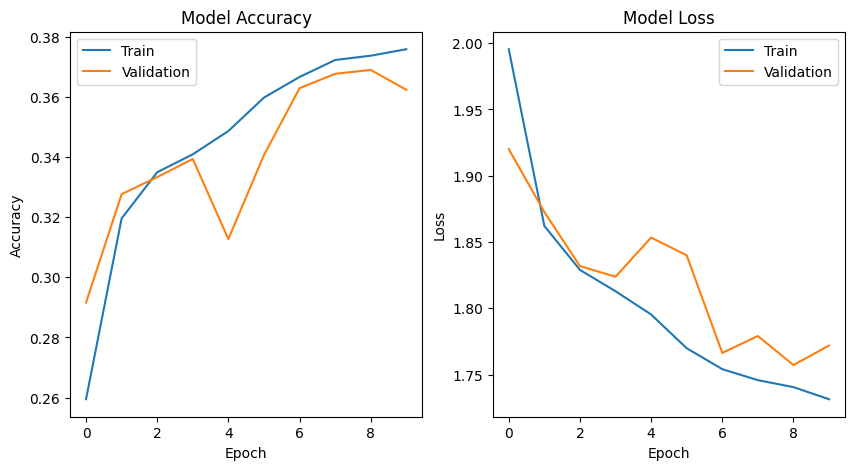

313/313 - 1s - loss: 1.7506 - accuracy: 0.3695 - 730ms/epoch - 2ms/step

Test accuracy: 0.3695000112056732
313/313 [==============================] - 1s 3ms/step

Classification report:
               precision    recall  f1-score   support

           0       0.41      0.51      0.45      1000
           1       0.54      0.40      0.46      1000
           2       0.28      0.09      0.14      1000
           3       0.21      0.06      0.09      1000
           4       0.28      0.31      0.29      1000
           5       0.29      0.45      0.35      1000
           6       0.41      0.36      0.38      1000
           7       0.35      0.54      0.43      1000
           8       0.39      0.57      0.46      1000
           9       0.48      0.41      0.44      1000

    accuracy                           0.37     10000
   macro avg       0.36      0.37      0.35     10000
weighted avg       0.36      0.37      0.35     10000



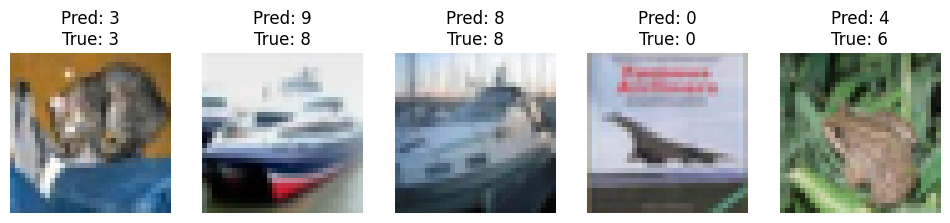

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report

# Load the CIFAR-10 dataset
cifar10 = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define the model
model = Sequential([
    Flatten(input_shape=(32, 32, 3)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, epochs=10, validation_split=0.2)

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

# Predict and visualize predictions
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Classification report
print('\nClassification report:\n', classification_report(test_labels, predicted_classes))

# Visualize the first 5 test images and their predicted labels
plt.figure(figsize=(12, 12))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(test_images[i])
    plt.title(f'Pred: {predicted_classes[i]}\nTrue: {test_labels[i][0]}')
    plt.axis('off')
plt.show()


## Explanation of Neural Network Training and Evaluation with TensorFlow and Keras

### Introduction
The provided code is a complete example of training a neural network on the cifar10 dataset using TensorFlow's high-level Keras API. It includes steps from loading and preprocessing data to training the model and visualizing its performance.

### Key Functions and Their Roles:

#### Data Loading and Preprocessing

- `tf.keras.datasets.cifar10.load_data()`: Loads the cifar10.
- Normalization: The image pixel values are scaled from [0, 255] to [0, 1] to facilitate neural network training by providing numerical stability.

#### Model Construction
- `Sequential()`: Initializes a linear stack of layers in the model.
- `Flatten()`: Flattens the input images from a 2D array (28x28 pixels) to a 1D array (784 pixels).
- `Dense()`: Adds densely connected (fully connected) neural layers. The first `Dense` layer has 128 nodes (or neurons) with ReLU activation function, and the second serves as the output layer with 10 nodes corresponding to the 10 classes of the dataset, using softmax activation for multi-class classification.

#### Model Compilation
- `compile()`: Configures the model for training with the following parameters:
  - `optimizer='adam'`: Utilizes the Adam optimizer (an algorithm for first-order gradient-based optimization of stochastic objective functions).
  - `loss='sparse_categorical_crossentropy'`: Sets the loss function for multi-class classification.
  - `metrics=['accuracy']`: Evaluates the model during training and testing.

#### Model Training
- `fit()`: Trains the model for a specified number of epochs (iterations over the entire dataset), here set to 10, and includes a validation split of 20%.

#### Performance Visualization
- Matplotlib's plotting functions (`plt.figure()`, `plt.plot()`, `plt.subplot()` etc.) are used to create line graphs for training and validation accuracy and loss, providing insights into the learning process and potential overfitting.

#### Model Evaluation and Prediction
- `evaluate()`: Tests the model on the testing set to assess its performance in terms of loss and accuracy.
- `predict()`: Generates output predictions for the input samples from the test set.

#### Visualization of Predictions
- Uses `plt.imshow()` to display the first five test images alongside their predicted and true labels, helping visually assess the model's predictive performance.

### Conclusion
This code effectively demonstrates the workflow of using TensorFlow with Keras to build, train, and evaluate a neural network, along with detailed visual analysis of its performance metrics and predictions. It is an excellent starting point for experimenting with different neural network architectures and parameters.


## Future Work Suggestions for Neural Network Project on Fashion MNIST

### 1. **Experiment with Different Model Architectures**
   - **Deeper Networks**: Try adding more layers to the network to see if it improves accuracy.
   - **Convolutional Neural Networks (CNNs)**: Since the dataset involves images, CNNs could perform better in extracting hierarchical features.
   - **Residual Networks**: Implementing ResNet-like architectures could help in training deeper networks without running into the vanishing gradient problem.

### 2. **Hyperparameter Tuning**
   - **Optimizer Tweaks**: Experiment with different optimizers like SGD, RMSprop, and their parameters to find the best fit for this dataset.
   - **Learning Rate Adjustments**: Use learning rate schedules or adaptative learning rate methods to improve training dynamics.
   - **Regularization Techniques**: Implement dropout, L1/L2 regularization to reduce overfitting and improve model generalization.

### 3. **Advanced Training Techniques**
   - **Data Augmentation**: Introduce random rotations, scaling, and flips to the training images to make the model robust to variations in input.
   - **Batch Normalization**: Apply batch normalization to stabilize learning and improve convergence speed.
   - **Early Stopping**: Monitor validation loss and stop training when it begins to increase to prevent overfitting.

### 4. **Evaluation Metrics and Model Analysis**
   - **Confusion Matrix**: Analyze the confusion matrix to understand the model's performance across different classes better.
   - **ROC Curves and AUC Scores**: Evaluate model performance with ROC curves and calculate the area under the curve (AUC) for multiclass classification.
   - **Feature Visualization**: Use techniques like t-SNE for high-dimensional data visualization to inspect how features are being learned by the network.

### 5. **Expand Dataset Usage**
   - **Other Datasets**: Apply the trained models or techniques to similar datasets like CIFAR-10 to verify model versatility.
   - **Real-World Deployment**: Test the model with real-world clothing images from online catalogs or retail stores to evaluate practical applicability.

### 6. **Explainable AI**
   - **Model Interpretability**: Implement techniques to make the model's decisions interpretable in the context of fashion item recognition.
   - **Attention Mechanisms**: Use attention mechanisms to highlight areas of the image most relevant to the model’s predictions.

Implementing these suggestions could lead to improved model performance, deeper insights into the model's operations, and increased practical applications. Regularly reviewing and iterating on the model's design and training approach based on the latest research and technologies in machine learning will foster continued improvements.
